<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/GroverSearchAlgorithm_QiskitRuntime_mkbahk_20241107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install qiskit[all]==1.2.4
%pip install qiskit-ibm-runtime==0.32.0
%pip install qiskit-transpiler-service==0.4.10
%pip install qiskit-aer==0.15.1
%pip install qiskit.algorithms==0.3.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.0/524.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=cbbc4f5bfbaa864d99bcd206c7ac10a

#Qiskit Runtime Primitive-Sampler를 이용한 그로버탐색 알고리즘 구현
## 검색문제 정의
8명 사람의 전화번호가 적혀 있는 전화번호부에서 만들어 전화번호부를 보지 않고, 우리의 추측이 맞았는지 틀렸는지 알려주는 오카클을 통해 특정한 전화번호의 주인을 검색

In [ ]:
# Oracle 생성
import random
from qiskit.quantum_info import Statevector

secret = random.randint(0, 7) # the owner is randomly picked
secret_string = format(secret, '03b') # format the owner in 3-bit string
oracle = Statevector.from_label(secret_string)

In [ ]:
oracle

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j],
            dims=(2, 2, 2))


In [ ]:
# Search Problem 생성
from qiskit_algorithms import AmplificationProblem # This import should now work

problem = AmplificationProblem(oracle=oracle, is_good_state=lambda x: x == secret_string)

In [ ]:
problem

그로버검색 알고리즘의 양자회를 생성, 여기서 알고리즘의 정확성은 iteration의 숫자가 많아질수록 올라감. 1번과 2번의 반복을 비교합니다.

In [ ]:
# Grover 알고리즘 회로
from qiskit_algorithms import Grover

grover_circuit = []
for iteration in range(1, 3):
  grover = Grover(iterations=iteration)
  circuit = grover.construct_circuit(problem)
  circuit.measure_all()
  grover_circuit.append(circuit)
###for

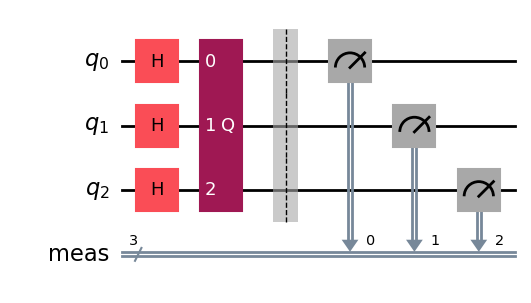

In [ ]:
grover_circuit[0].draw("mpl")

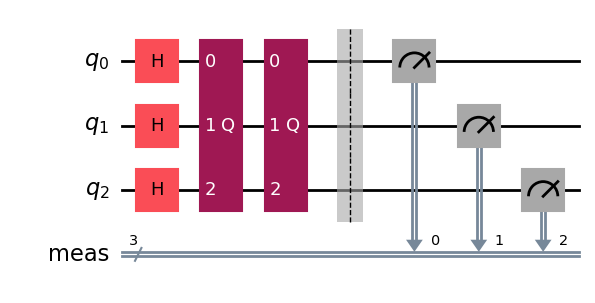

In [ ]:
grover_circuit[1].draw("mpl")

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler, Options, SamplerOptions

#from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_cloud",
                               token="",
                               instance="")

service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

In [ ]:
backend = service.backend("ibmq_qasm_simulator")
backend

<IBMBackend('ibmq_qasm_simulator')>

In [ ]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(grover_circuit)

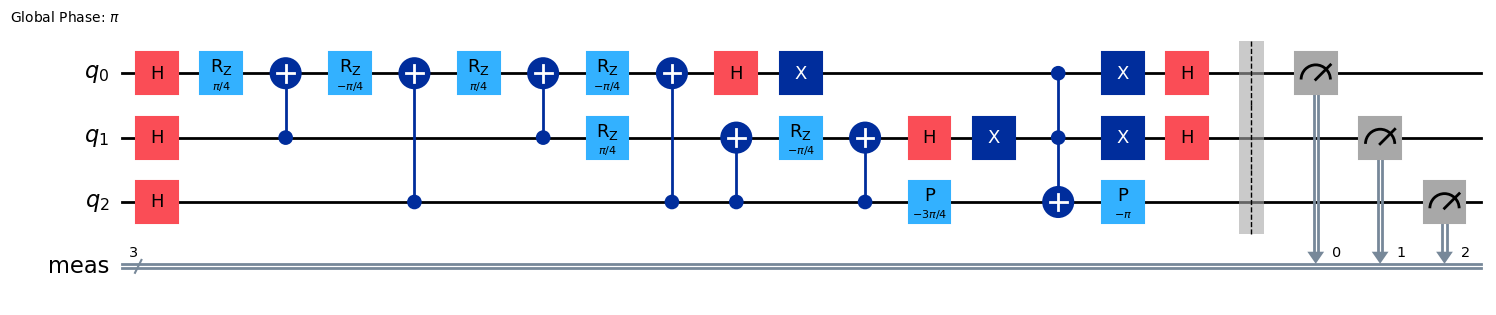

In [ ]:
isa_circuit[0].draw("mpl")

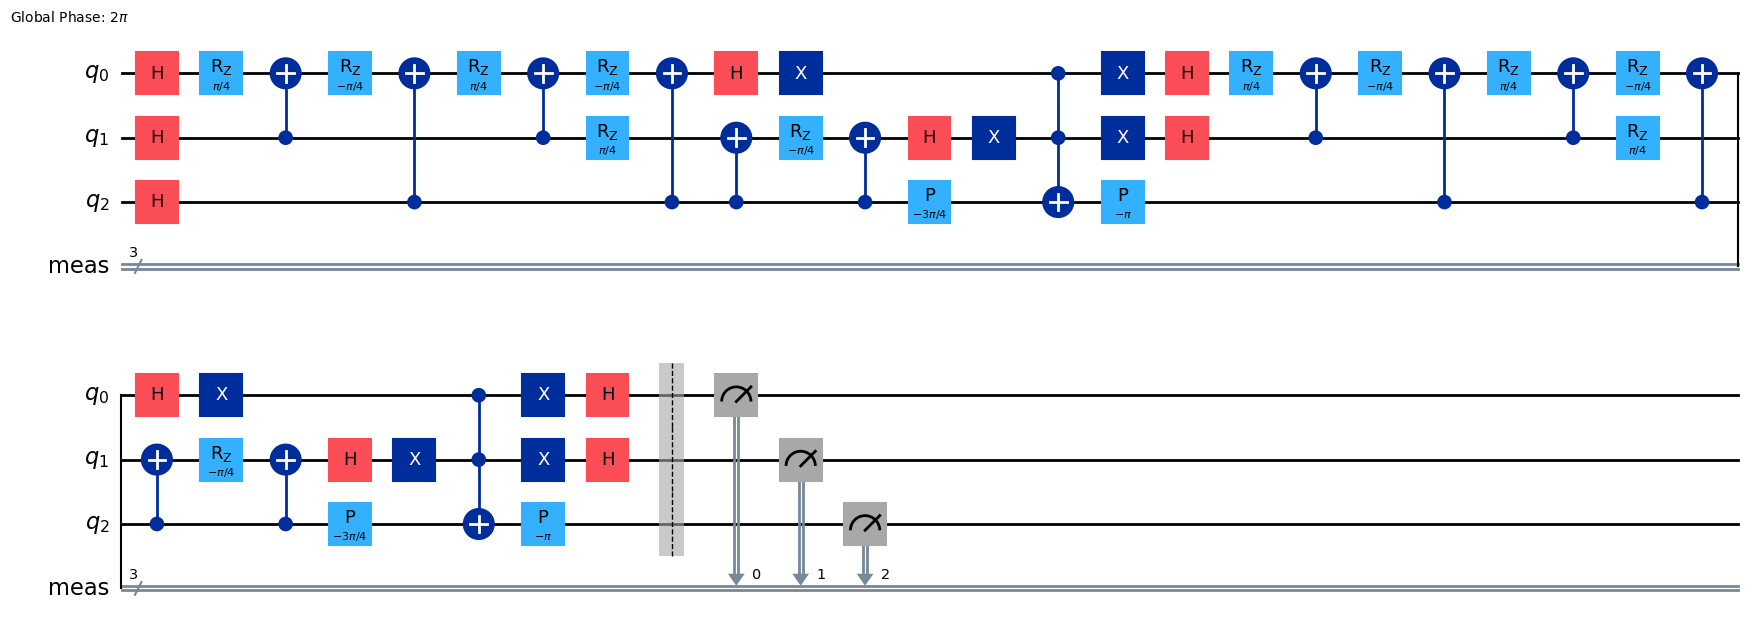

In [ ]:
isa_circuit[1].draw("mpl")

In [ ]:
options = SamplerOptions(simulator={"seed_simulator": 42})
with Session(backend=backend):
  sampler = Sampler(options=options)
  job = sampler.run(isa_circuit, shots=1024)
###

print("\n Job ID: ", job.job_id())


 Job ID:  csm5qiu8p6ivfmbf4vbg


In [ ]:
print("\n Job Status: ", job.status)


 Job Status:  <bound method RuntimeJobV2.status of <RuntimeJobV2('csm5qiu8p6ivfmbf4vbg', 'sampler')>>


In [ ]:
result = job.result()
result

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-11-07 06:25:20', stop='2024-11-07 06:25:20', size=2048>)])}, 'version': 2})

In [ ]:
counts1 = result[0].data.meas.get_counts()
counts2

{'111': 975,
 '110': 10,
 '100': 3,
 '101': 6,
 '011': 9,
 '001': 5,
 '000': 12,
 '010': 4}

In [ ]:
counts2 = result[1].data.meas.get_counts()
counts2

{'111': 975,
 '110': 10,
 '100': 3,
 '101': 6,
 '011': 9,
 '001': 5,
 '000': 12,
 '010': 4}

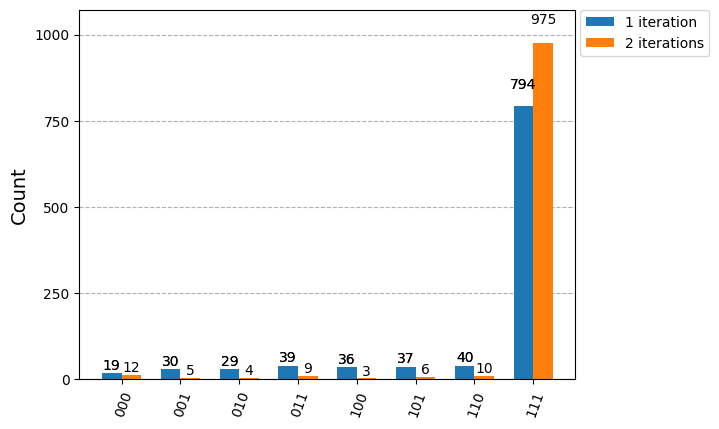

In [ ]:
plot_histogram([counts1, counts2], legend=["1 iteration","2 iterations"])